In [105]:
using Revise
using JLD2
using Plots
import Tensor_FixedSeedMC as TCIMC
using LinearAlgebra
using Statistics

In [106]:
#JLD2.@load "price_matrix_asianbarrier.jld2" price_matrix
JLD2.@load "../MC/MCdata/price_matrix_asianbarrier_N_PATHS1000000.jld2" res
price_matrix = res[1]

100×100 Matrix{Float64}:
  0.0      0.0      0.0      0.0     …   0.0      0.0      0.0      0.0
  0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
  0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
  0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
  0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
  0.0      0.0      0.0      0.0     …   0.0      0.0      0.0      0.0
  0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
  0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
  0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
  0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0
  ⋮                                  ⋱                             
 13.1505  13.1613  13.1722  13.1832     14.6029  14.6211  14.6393  14.6577
 13.4251  13.4354  13.4459  13.4566     14.8462  14.8642  14.8823  14.9003
 13.701   13.711   13.7211  13.7313  

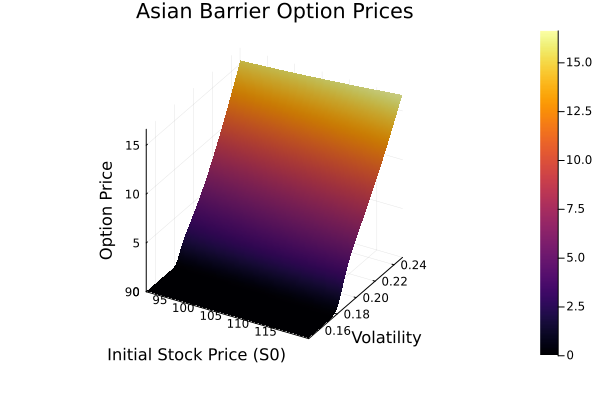

In [107]:
implied_vol_values = range(0.15, stop=0.25, length=101)[1:end-1]
S0_values = range(90, stop=120, length=101)[1:end-1]
# 3Dサーフェスプロット 
surface(S0_values, implied_vol_values, price_matrix, xlabel="Initial Stock Price (S0)", ylabel="Volatility", 
        zlabel="Option Price", title="Asian Barrier Option Prices")

In [108]:
@show S0_values[50]
@show S0_values[51]

S0_values[50] = 104.7
S0_values[51] = 105.0


105.0

In [109]:
price_matrix;

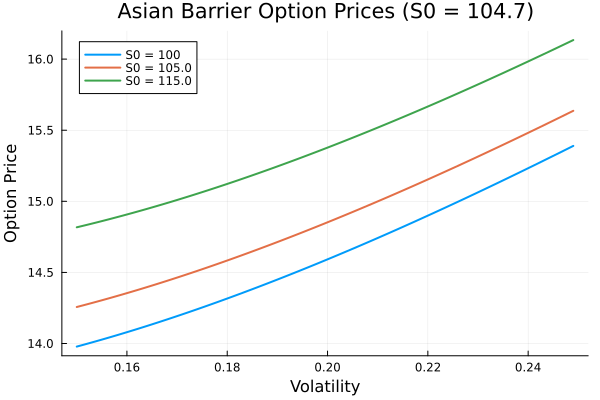

In [110]:
plot(implied_vol_values, price_matrix[95, :], xlabel="Volatility", ylabel="Option Price", 
     title="Asian Barrier Option Prices (S0 = 104.7)", label="S0 = 100", lw=2)

plot!(implied_vol_values, price_matrix[96, :], label="S0 = 105.0", lw=2)

plot!(implied_vol_values, price_matrix[98, :], label="S0 = 115.0", lw=2)

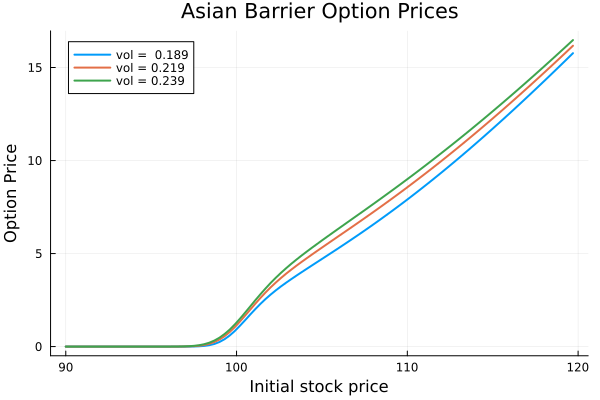

In [111]:
plot(S0_values, price_matrix[:, 40], xlabel="Initial stock price", ylabel="Option Price", 
     title="Asian Barrier Option Prices", label="vol =  0.189", lw=2)
plot!(S0_values, price_matrix[:, 70], label="vol = 0.219", lw=2)
plot!(S0_values, price_matrix[:, 90], label="vol = 0.239", lw=2)

In [112]:
using LinearAlgebra
U, S, Vt = svd(price_matrix)

function svd_with_tolerance(matrix, tolerance, maxbonddim=1000)
    factorization = svd(matrix)
   trunci = min(replacenothing(findlast(>(tolerance), factorization.S / maximum(factorization.S)), 1), maxbonddim)
   return factorization.U[:, 1:trunci], Diagonal(factorization.S[1:trunci]) * factorization.Vt[1:trunci, :]
end

function replacenothing(value::Union{T, Nothing}, default::T)::T where {T}
    if isnothing(value)
        return default
    else
        return value
    end
end

replacenothing (generic function with 1 method)

In [113]:
tol = 1e-4
U, SVt = svd_with_tolerance(price_matrix, tol)
@show size(U)
@show size(SVt)

size(U) = (100, 3)
size(SVt) = (3, 100)


(3, 100)

In [114]:
U_core = reshape(U, 1, size(U)[1], size(U)[2])
SVt_core = reshape(SVt, size(SVt)[1], size(SVt)[2], 1)

tt = [U_core, SVt_core]

2-element Vector{Array{Float64, 3}}:
 [4.440892098500626e-16 0.0 … -0.20619116902036924 -0.20968792003353154;;; -8.187894806610529e-16 2.220446049250313e-16 … -0.19249208288496622 -0.20316049940522482;;; -7.66053886991358e-15 -2.393918396847994e-16 … 0.13962956802749468 0.1598774132314993]
 [-69.64081814980425 -69.75580523426528 … -82.42064443612367 -82.559602260186; -3.9374096198902597 -3.8495291320470333 … 3.1834718689722337 3.2419628931265714; -0.12206518447576689 -0.11366954614260757 … -0.10338545277656701 -0.10933373304692882;;;]

In [115]:
maximum(price_matrix)

16.63678777457299

In [116]:
@show maximum(abs.(price_matrix .- U * SVt))

maximum(abs.(price_matrix .- U * SVt)) = 0.0036626169767366434


0.0036626169767366434

In [117]:
@show size(tt[1])
@show size(tt[2])

size(tt[1]) = (1, 100, 3)
size(tt[2]) = (3, 100, 1)


(3, 100, 1)

In [118]:
indexset = [1, 2]
function tt_evaluate(tt::Vector{Array{V,3}}, indexset) where {V}
    only(prod(T[:, i, :] for (T, i) in zip(tt, indexset)))
end

res1_2 = tt_evaluate(tt, indexset)

-2.6955076493570467e-14

In [119]:
@time tt_evaluate(tt, indexset)

  0.000017 seconds (7 allocations: 288 bytes)


-2.6955076493570467e-14

In [120]:
abs(price_matrix[1, 2] - res1_2)

2.6955076493570467e-14

In [121]:
indexset = [100, 90]
res100_100 = tt_evaluate(tt, indexset)
abs(price_matrix[100, 90] - res100_100)

6.462272008889158e-5

In [122]:
using JLD2
JLD2.@load "../MC/MCdata/price_matrix_asianbarrier_N_PATHS50000000.jld2" res
true_vals = res[1]

100-element Vector{Any}:
  0.0
  7.3066800509973096
  0.0
 13.172578842679838
  3.895564162594208
  9.282700454297311
  0.3729402654334533
  0.0026272220437503734
 12.290172129849152
  8.139546209105534
  ⋮
  3.499886669214271
  0.3027069566361018
  7.039978264292636
 12.265854488127252
  7.931150515344597
  3.8020564174262415
  0.1253142981532405
 16.223960804609685
  0.0041616458707820205

In [123]:
random_combinations = TCIMC.generate_random_combinations(100, 2, 100);
tt_res = []
for i in random_combinations
    push!(tt_res, TCIMC.tt_evaluate(tt, i))
end

@show mean(abs.(tt_res .- true_vals))
@show std(abs.(tt_res .- true_vals))
@show maximum(abs.(tt_res .- true_vals))
@show findmax(abs.(tt_res .- true_vals))
@show random_combinations[findmax(abs.(tt_res .- true_vals))[2]]

mean(abs.(tt_res .- true_vals)) = 0.0022831776102378433
std(abs.(tt_res .- true_vals)) = 0.0019512012695263475
maximum(abs.(tt_res .- true_vals)) = 0.005979571806255635
findmax(abs.(tt_res .- true_vals)) = (0.005979571806255635, 4)
random_combinations[(findmax(abs.(tt_res .- true_vals)))[2]] = [87, 85]


2-element Vector{Int64}:
 87
 85